## Import dependencies

We start by importing TensorFlow and other supporting libraries that are used for data processing and visualization.

In [14]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.
![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [15]:
test_images = np.load("to_test_images.npy")
test_labels = np.load("to_test_labels.npy")

In [16]:
# Normalize the input image so that each pixel value is between 0 to 1.
#test_images = test_images / 255.0
#print('Pixels are normalized')
print('Pixels are already normalized')

Pixels are already normalized


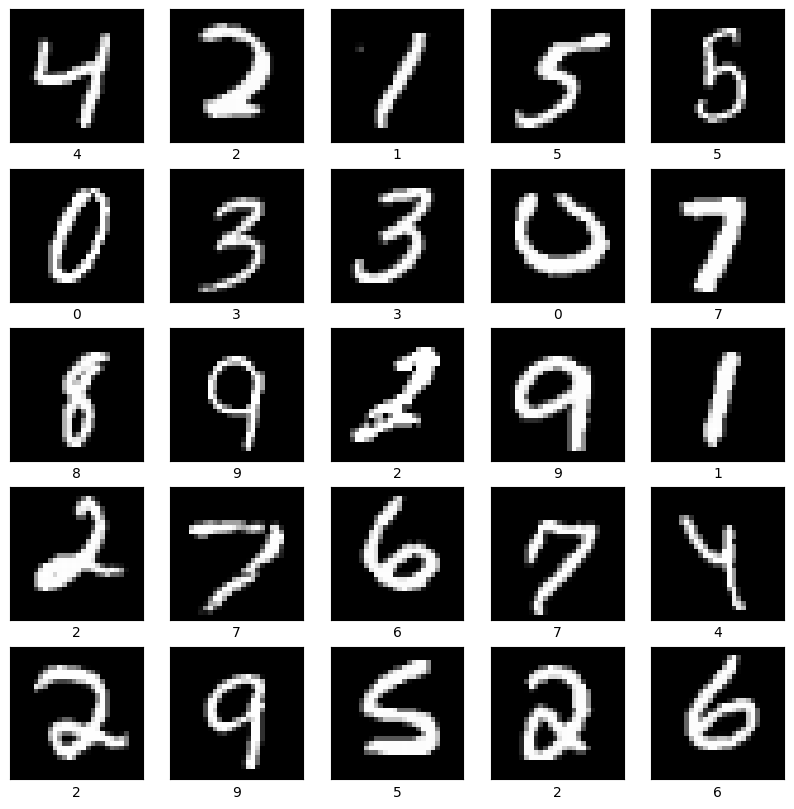

In [17]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_images[i], cmap=plt.cm.gray)
  plt.xlabel(test_labels[i])
plt.show()

### To RUN on tflite_runtime

In [18]:
import tflite_runtime.interpreter as tflite

model_path = 'mnist.tflite'

def predict(images):
  # Initialize TFLite interpreter using the model.
  interpreter = tflite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for image in images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    image = np.expand_dims(image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, image)

    # Run inference.
    interpreter.invoke()

    pred = [0 for i in range(10)]
    for i in range(10):
      pred[i] = output()[0][i]

    prediction_digits.append(pred)

  return prediction_digits

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model():
  # Initialize TFLite interpreter using the model.
  interpreter = tflite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

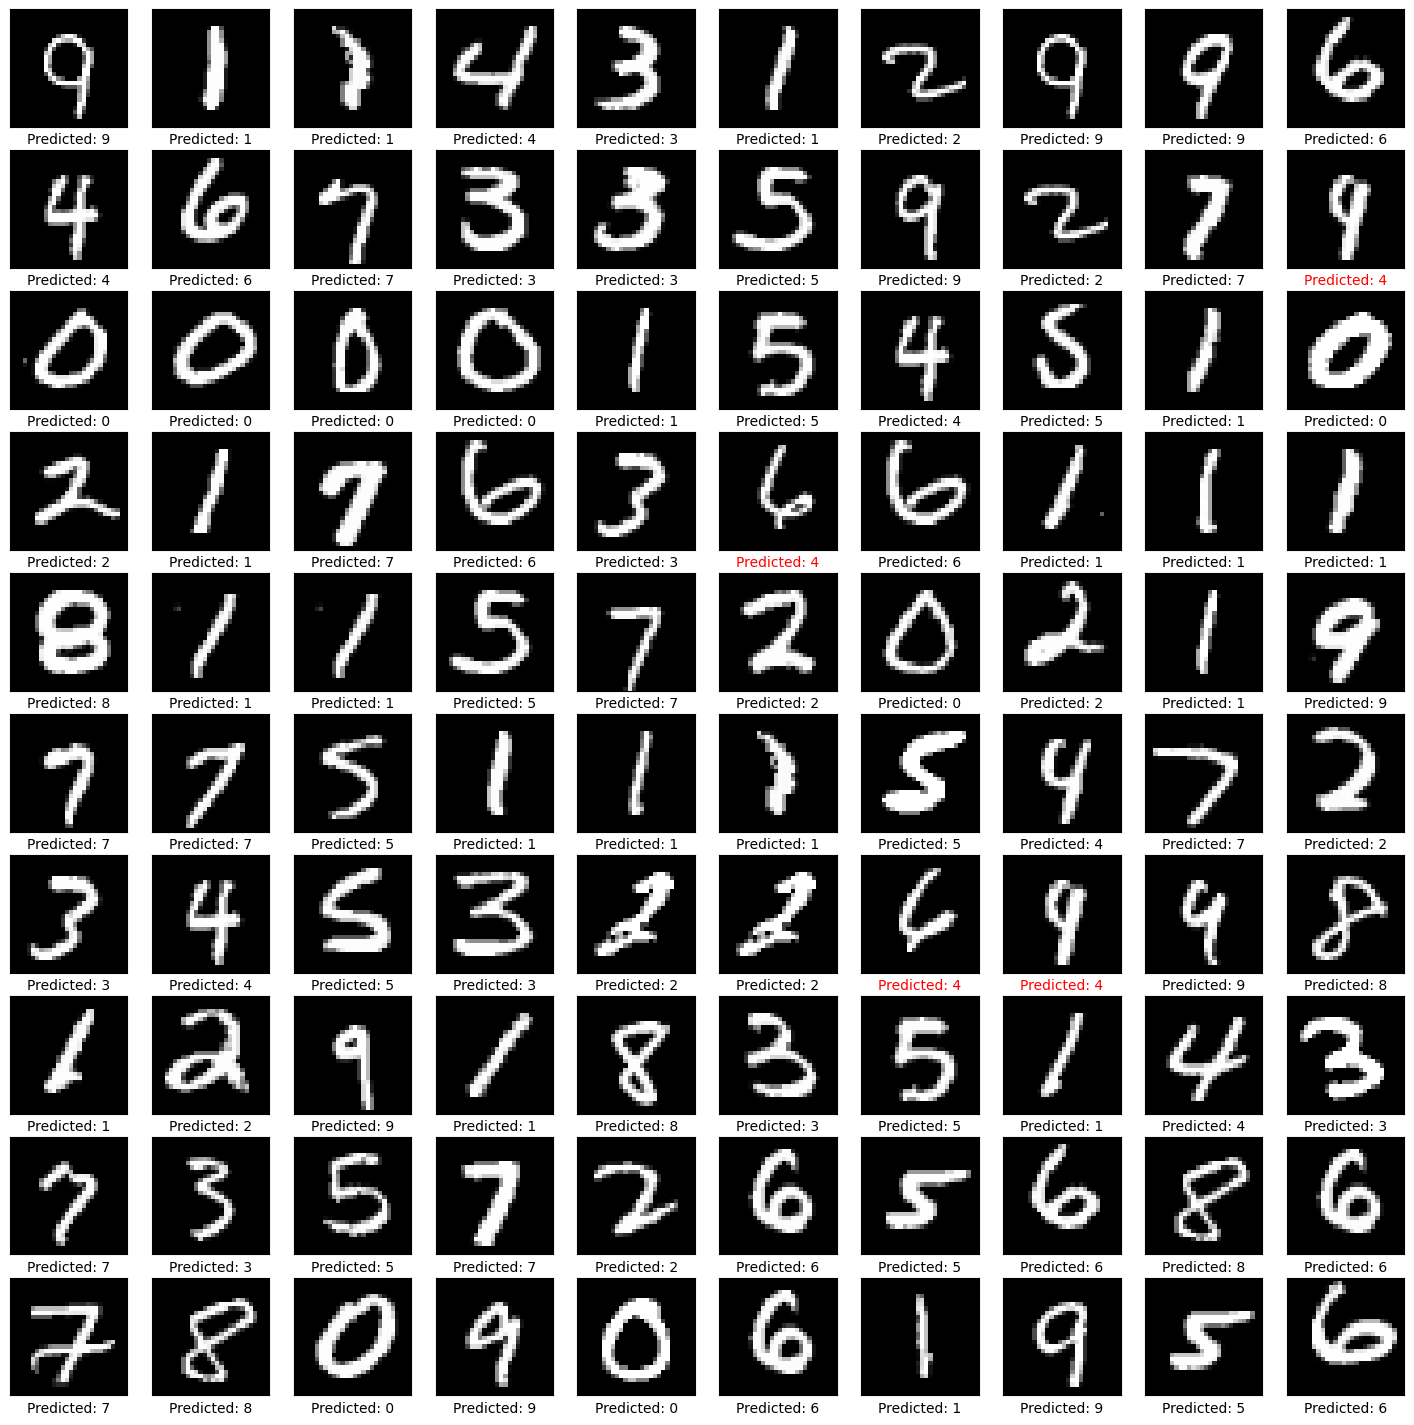

In [19]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [20]:
# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
accuracy = evaluate_tflite_model()
print('model accuracy = %.4f' % accuracy)

model accuracy = 0.9850
